### Description:
One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

**Acknowledgements**
The dataset is taken from Kaggle.

In [107]:
pip install category-encoders


Note: you may need to restart the kernel to use updated packages.


In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV 
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression , Ridge 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [109]:
sales=pd.read_csv("D:\MLOPS\Walmart.csv")
sales

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


### Understanding of Data

In [110]:
print("shape of data is: {}".format(sales.shape))
print("Null values in data are :{}".format(sales.isnull().sum()))

shape of data is: (6435, 8)
Null values in data are :Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [111]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [112]:
sales['Date']=pd.to_datetime(sales['Date'],format='mixed')

### EDA and Feature Engineering

In [113]:
sales['month']=sales['Date'].dt.month
sales['year']=sales['Date'].dt.year

In [114]:
def get_season(month):
    if month in [12,1,2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Fall'

In [115]:
sales['season']=sales['month'].apply(get_season)

In [116]:
sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year,season
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,5,2010,Spring
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,12,2010,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,Winter
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,5,2010,Spring


In [117]:
sales.describe()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,month,year
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 20:18:27.692307712,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,6.475524,2010.965035
min,1.000000,2010-01-10 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,1.000000,2010.000000
25%,12.000000,2010-10-12 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,2010.000000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,6.000000,2011.000000
75%,34.000000,2012-03-02 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,9.000000,2012.000000
max,45.000000,2012-12-10 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,12.000000,2012.000000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,3.321797,0.797019


**The Consumer Price Index (CPI) measures the monthly change in prices paid by U.S. consumers. The Bureau of Labor Statistics (BLS) calculates the CPI as a weighted average of prices for a basket of goods and services representative of aggregate U.S. consumer spending.The CPI is a measure of inflation and deflation.**

#### Univariate Analysis

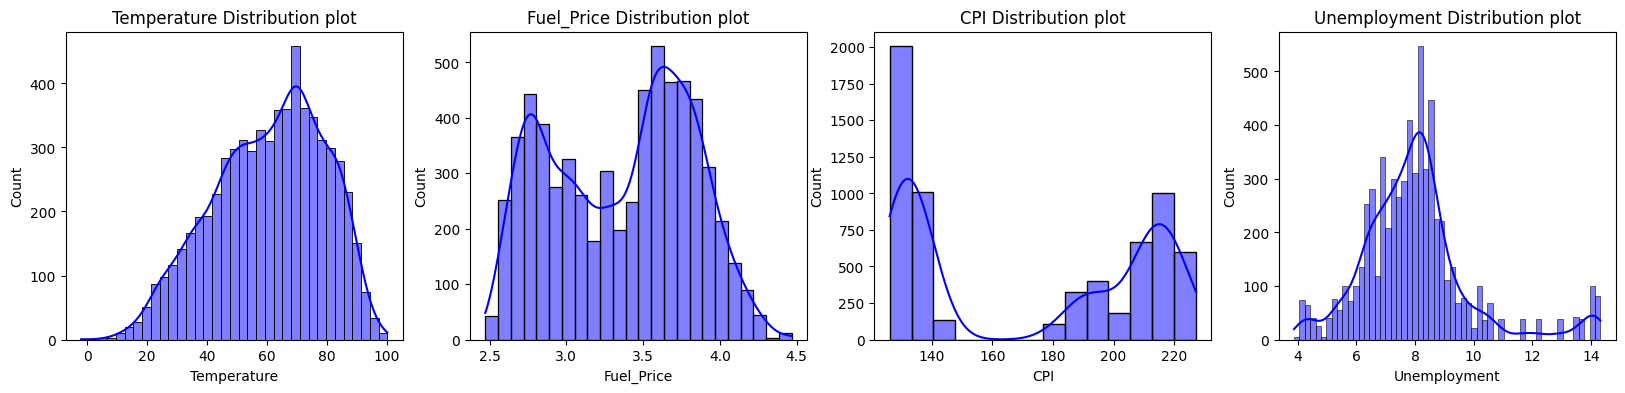

In [118]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
cols=['Temperature', 'Fuel_Price', 'CPI','Unemployment']

for i, col in enumerate(cols):
    sns.histplot(sales,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 color='blue'
                 )
    ax[i].set_title(f'{col} Distribution plot')
fig.show()

Temperatue and Unemployement mostly follows normal distribution

Fuel Prices and CPI distributions appears to be bimodal(having two peaks)

Temperature: Seasonal variations might impact sales.

Fuel Price: Higher fuel prices could reduce customer spending.

CPI: Inflation could lower the purchasing power, leading to lower sales.

Unemployment: Higher unemployment could negatively affect consumer demand.




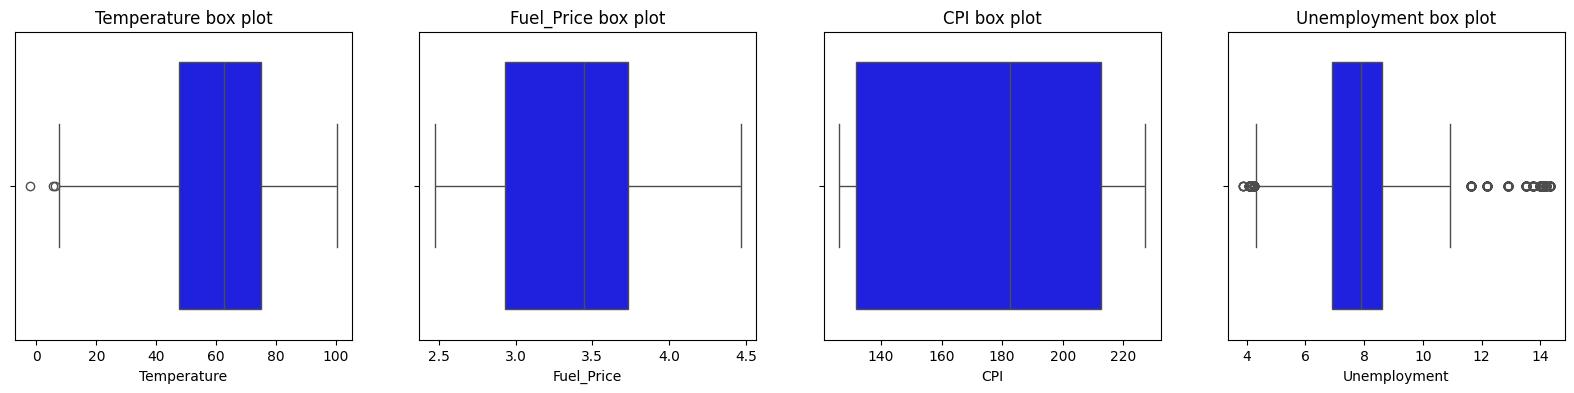

In [119]:
fig,ax=plt.subplots(1,4,figsize=(20,4))

cols=['Temperature', 'Fuel_Price', 'CPI','Unemployment']

for i,col in enumerate(cols):
    sns.boxplot(sales,
                x=col,
                ax=ax[i],
                color='blue'
                )
    ax[i].set_title(f'{col} box plot')

fig.show()
    

There are several outilers on the higher end above 12%

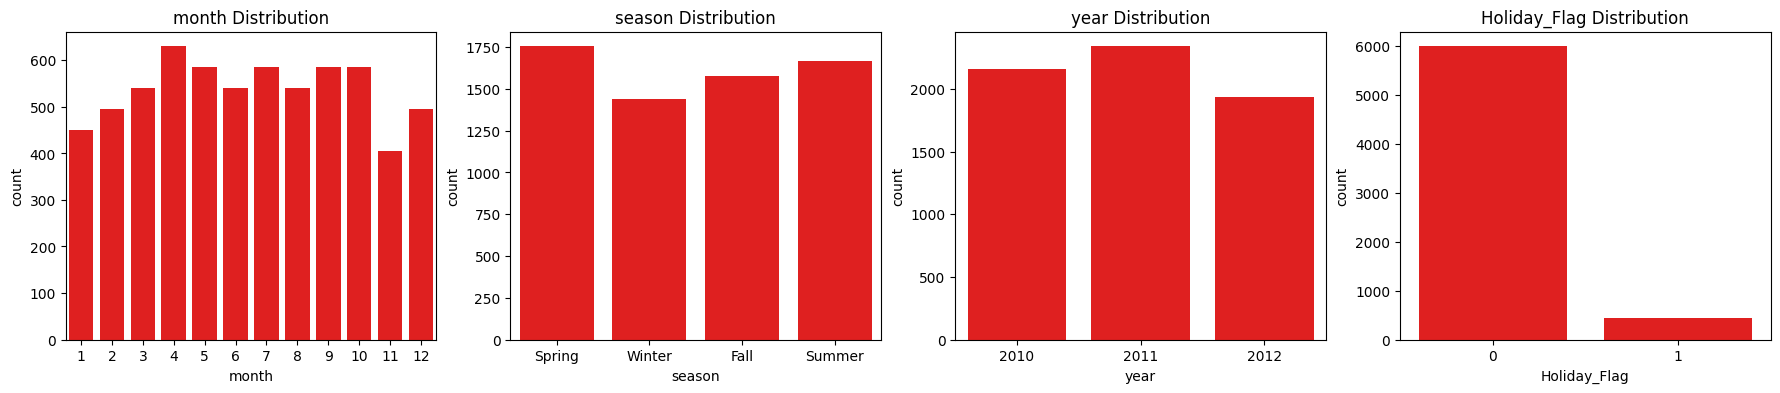

In [120]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['month','season','year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.countplot(sales,
                 x=col,
                 ax=ax[i],
                 color = 'Red'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()  

Text(0.5, 1.0, 'Weekly_Sales Distribution')

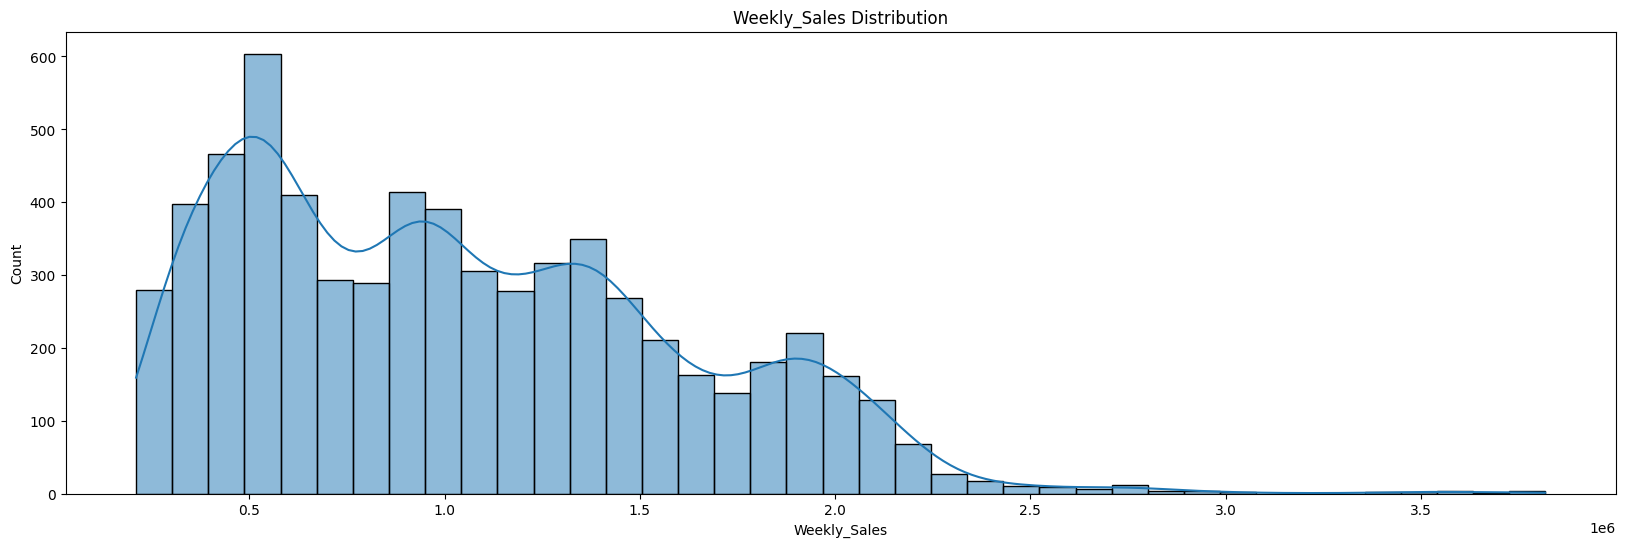

In [121]:
plt.figure(figsize=(20,6))
sns.histplot(x=sales['Weekly_Sales'],kde=True)
plt.title('Weekly_Sales Distribution')

Text(0.5, 1.0, 'Weekly_Sales Boxplot')

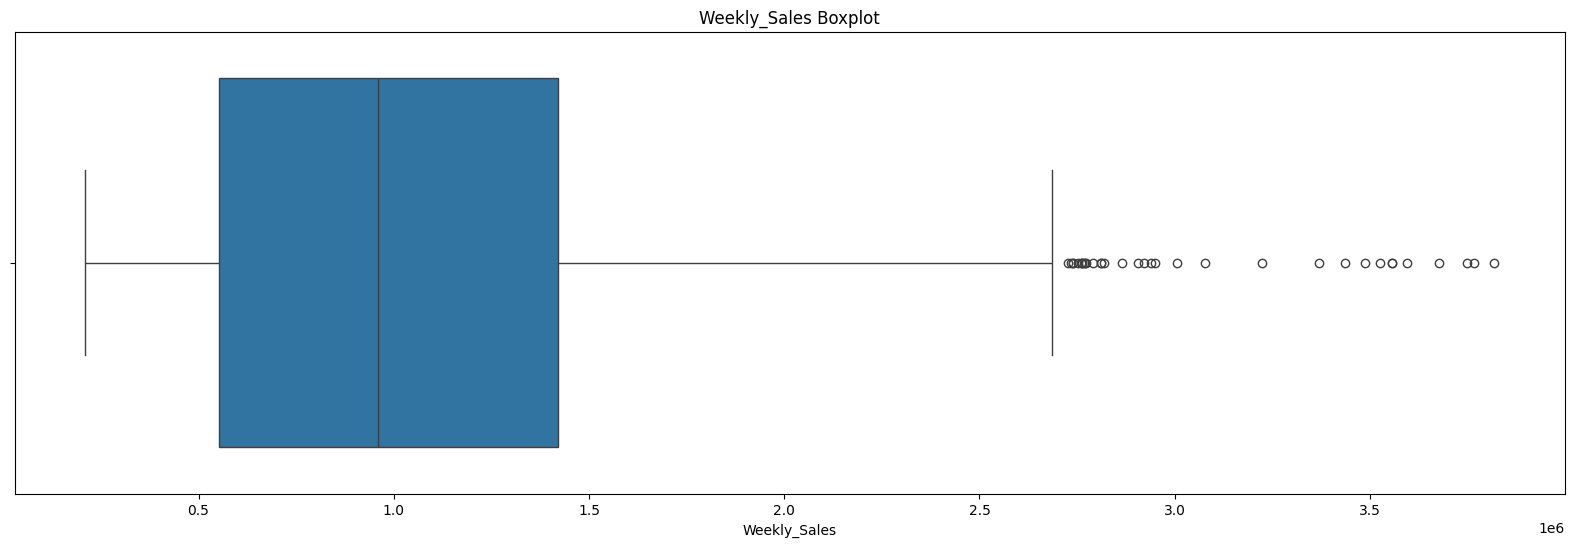

In [122]:
plt.figure(figsize=(20,6))
sns.boxplot(x=sales['Weekly_Sales'])

plt.title('Weekly_Sales Boxplot')

Weekly sales are right skewed and have some outliers which needs to be adjusted

#### Bivariate Analysis

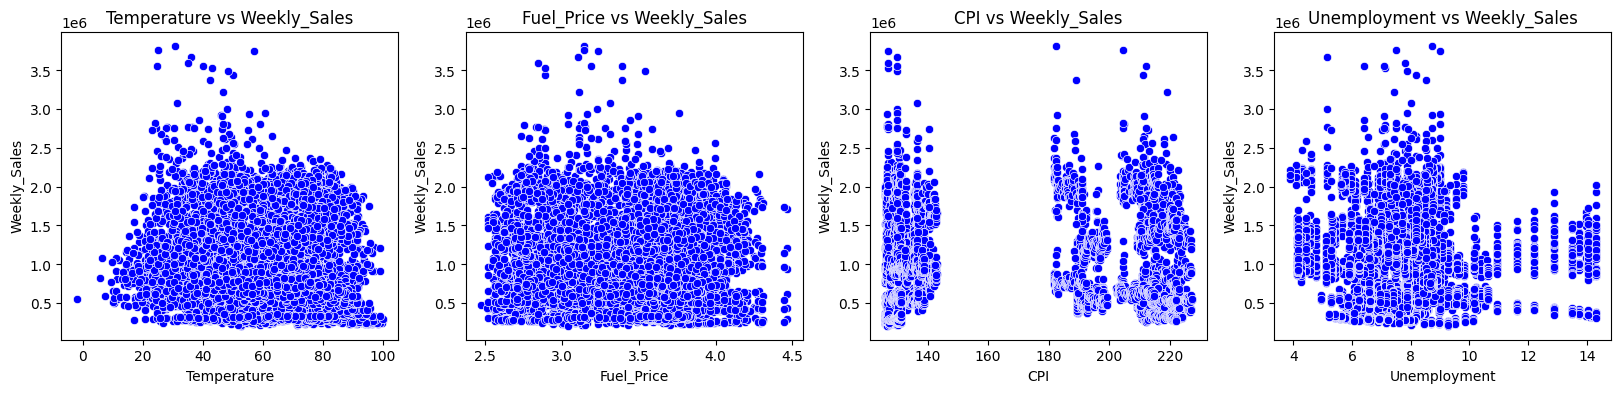

In [123]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
cols=['Temperature', 'Fuel_Price', 'CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(sales,
                    x=col,
                    y='Weekly_Sales',
                    ax=ax[i],
                    color='blue')
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()

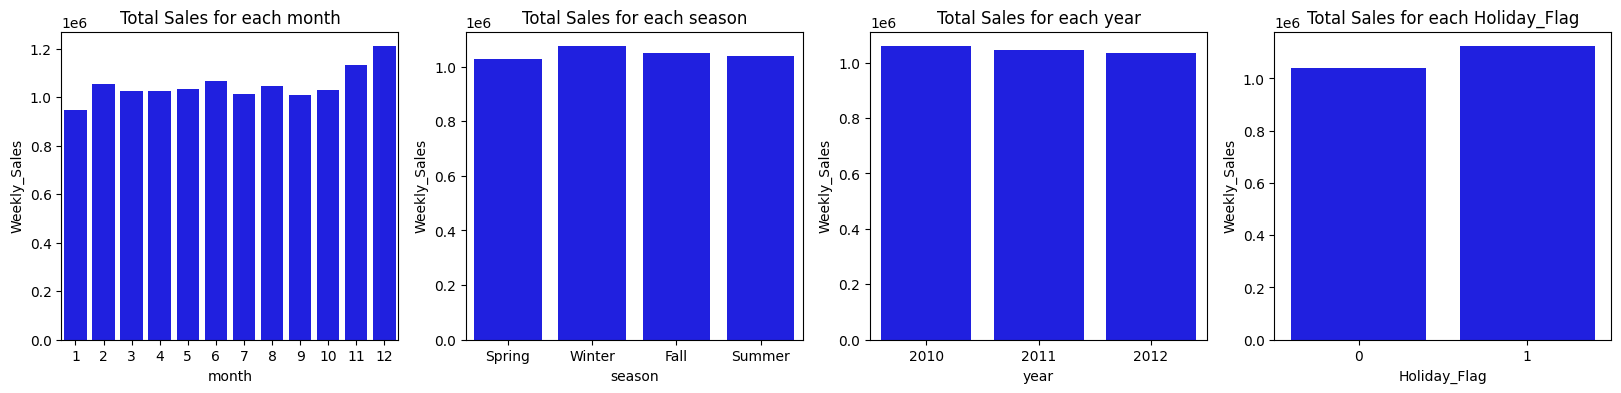

In [124]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
cols=['month', 'season', 'year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.barplot(sales,
                    x=col,
                    y='Weekly_Sales',
                    ax=ax[i],
                    errorbar=None,
                    color='blue')
    ax[i].set_title(f'Total Sales for each {col}')
fig.show()

- Sales are higher in winter and holidays
- Sales are higher in Months 11,12.

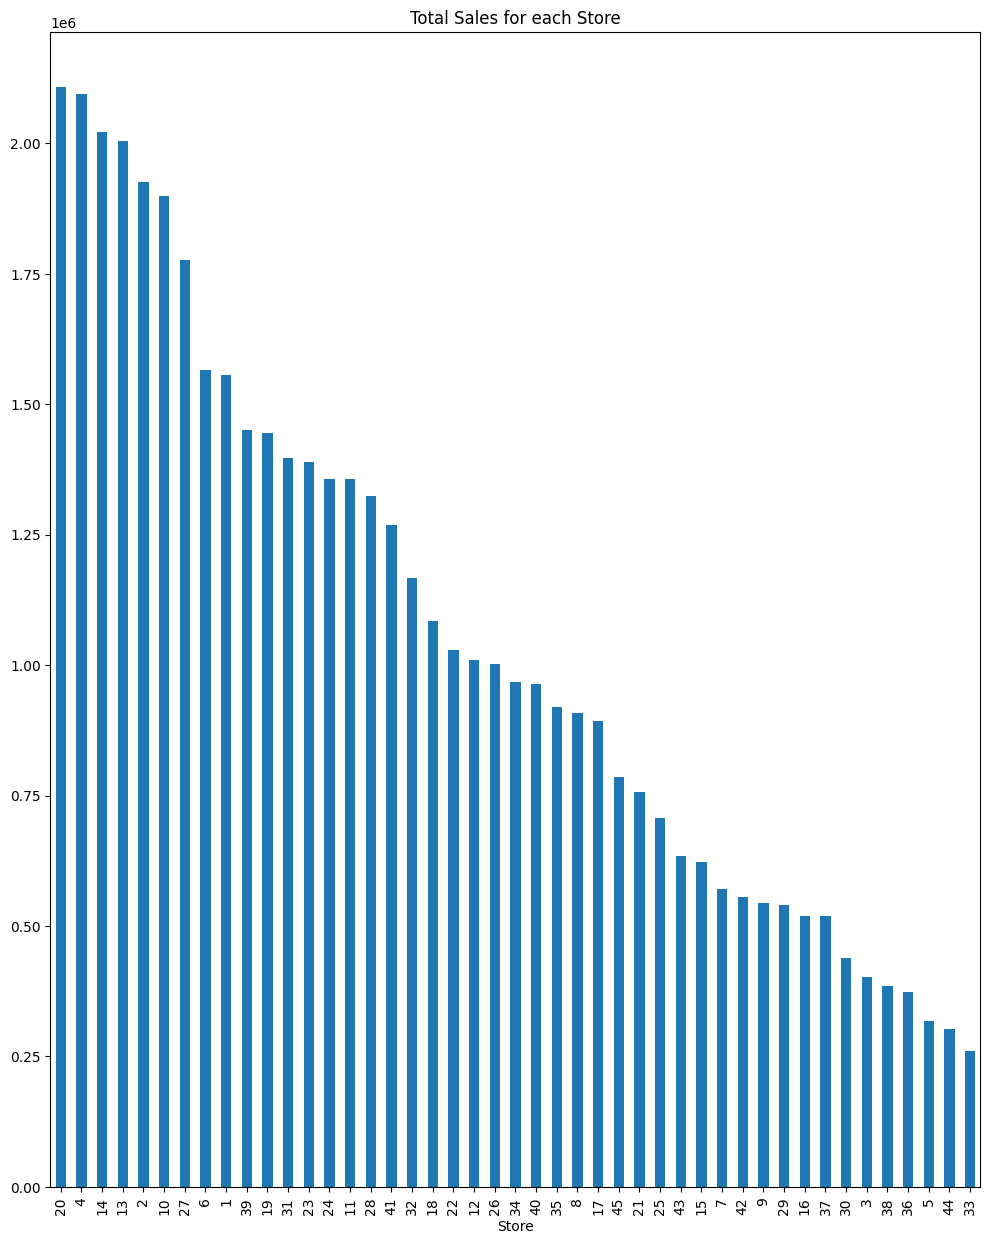

In [125]:
plt.figure(figsize=(12,15))
sales.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Total Sales for each Store');

- Stores 20,4,14,13,2 achieved the highestsales with sales over 2M while stores like 33,44,5 achieve the lowest sales with sales around 0.25M.

In [126]:
sales['Store'].dtype

dtype('int64')

In [127]:
sales['Store']=sales['Store'].astype('object')

Text(0.5, 1.0, 'Weekly Sales over 3 years')

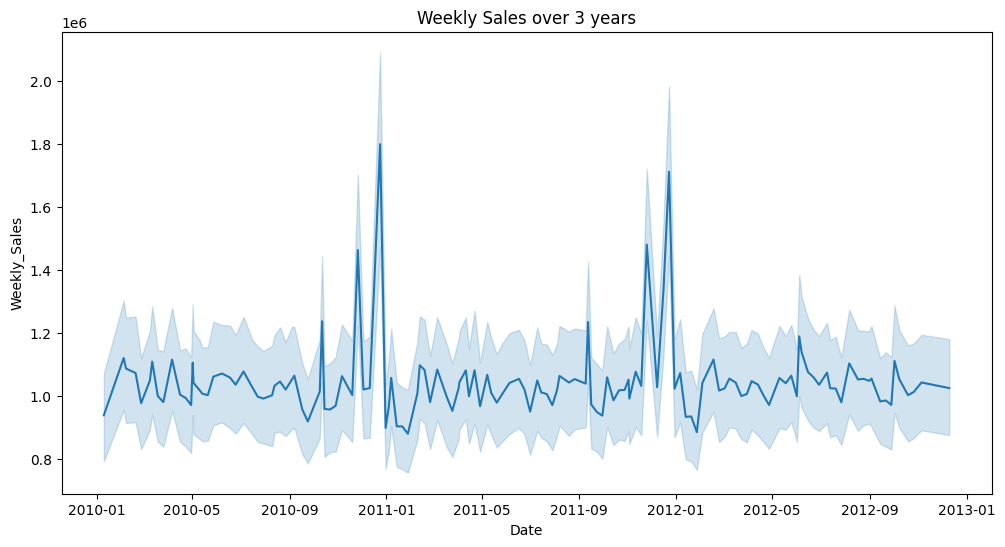

In [128]:
plt.figure(figsize=(12,6))
sns.lineplot(x=sales['Date'],y=sales['Weekly_Sales'])

plt.title('Weekly Sales over 3 years')

Text(0.5, 1.0, 'Sales over each month')

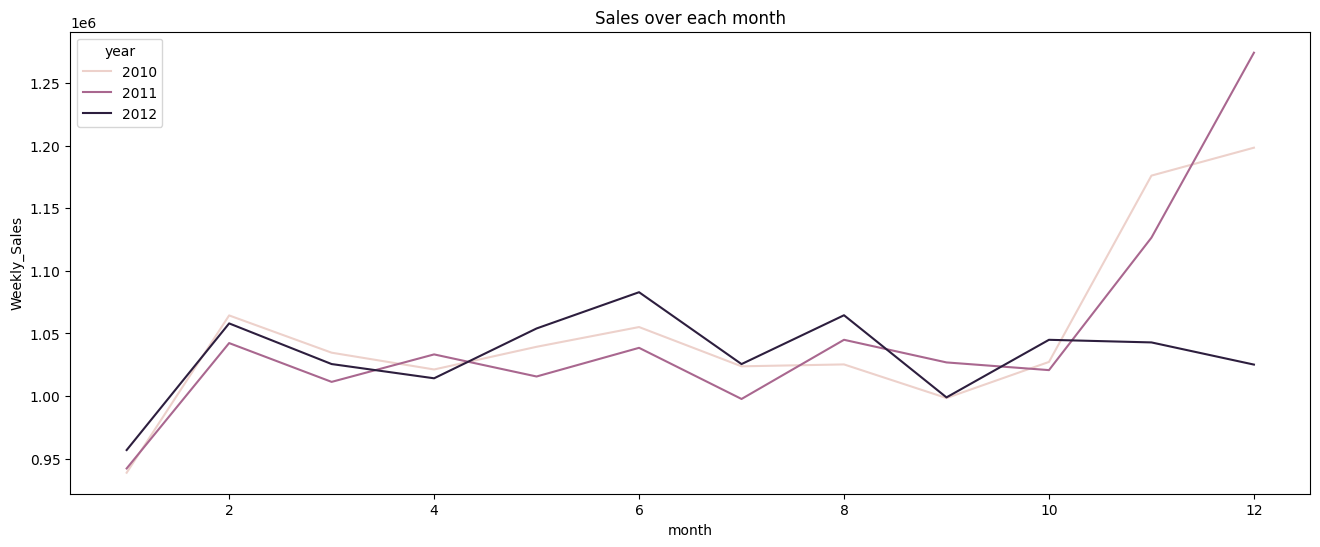

In [129]:
plt.figure(figsize=(16,6))
sns.lineplot(x=sales['month'],y=sales['Weekly_Sales'],hue=sales['year'],ci=None)
plt.title('Sales over each month')

<Axes: >

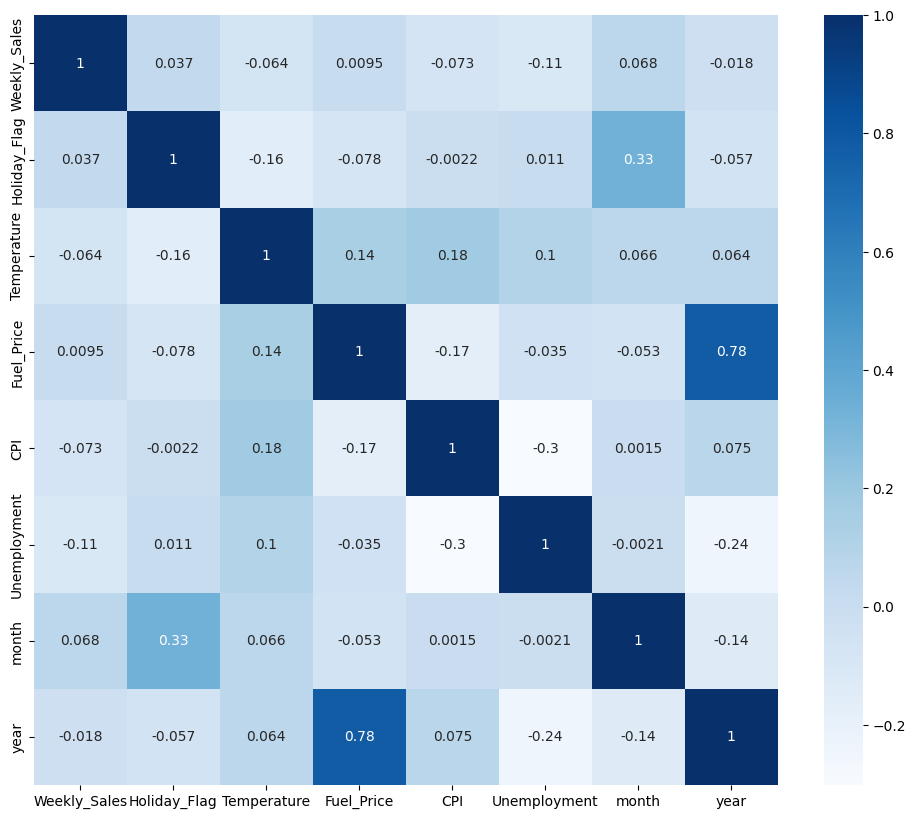

In [130]:
plt.figure(figsize=(12,10))
sns.heatmap(sales.corr(numeric_only=True),cmap='Blues',annot=True)

### Removing Outliers

In [131]:
num_features=['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']
for feature in num_features:
    Q1 = sales[feature].quantile(0.25)
    Q3=sales[feature].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    sales=sales[(sales[feature]>=lower_bound) & (sales[feature]<=upper_bound)]

### Model Building

In [132]:
def finetune_and_evaluate(model,param_grid):
    grid_search=GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='r2')
    grid_search.fit(X_train,y_train)
    best_params=grid_search.best_params_
    best_model=grid_search.best_estimator_
    best_score=grid_search.best_score_
    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')

    print('Train accuracy',round(best_model.score(X_train, y_train),3)*100)
    print('Test accuracy',round(best_model.score(X_test, y_test),3)*100)

    return best_model

In [133]:
num_vars = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']

# scaling numerical variables
sc = StandardScaler()
sales[num_vars]=sc.fit_transform(sales[num_vars])

# encoding categorical features
encoder = BinaryEncoder(cols=['Store','season'])
sales=encoder.fit_transform(sales)

In [134]:
features = sales.columns.drop(['Weekly_Sales','Date','year'])
target = 'Weekly_Sales'

X=sales[features]
y=sales[target]
X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=42 ,  test_size=0.2)

### 1. Linear Regression

In [135]:
lin_reg=make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

# hyperparameter tuning

param_grid={'polynomialfeatures__degree':[2,3,4]}
lin_reg=finetune_and_evaluate(lin_reg,param_grid)

Best Parameters: {'polynomialfeatures__degree': 3}
Best Score: 0.9557118092358458
Train accuracy 97.3
Test accuracy 95.5


### 2. Ridge

In [136]:
ridge=make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge()
)

param_grid={
    'polynomialfeatures__degree':[2,3,4],
    'ridge__alpha':[0.1,1,10]
}

ridge=finetune_and_evaluate(ridge,param_grid)

Best Parameters: {'polynomialfeatures__degree': 3, 'ridge__alpha': 0.1}
Best Score: 0.9557154773048474
Train accuracy 97.2
Test accuracy 95.5


### 3. KNNRegressor

In [137]:
knn=KNeighborsRegressor()
param_grid={
    'n_neighbors':np.arange(1,10),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']
}
knn=finetune_and_evaluate(knn,param_grid)

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best Score: 0.8137071614321906
Train accuracy 100.0
Test accuracy 83.0


### 4. Decision Tree

In [138]:
# building the model
dec_tree = DecisionTreeRegressor()

# hyperparameter tunning
param_grid = {'max_depth': np.arange(2,13)}
dec_tree = finetune_and_evaluate(dec_tree,param_grid)

Best Parameters: {'max_depth': 9}
Best Score: 0.9232560089625081
Train accuracy 96.8
Test accuracy 92.2


Text(0.5, 1.0, 'Feature Importance')

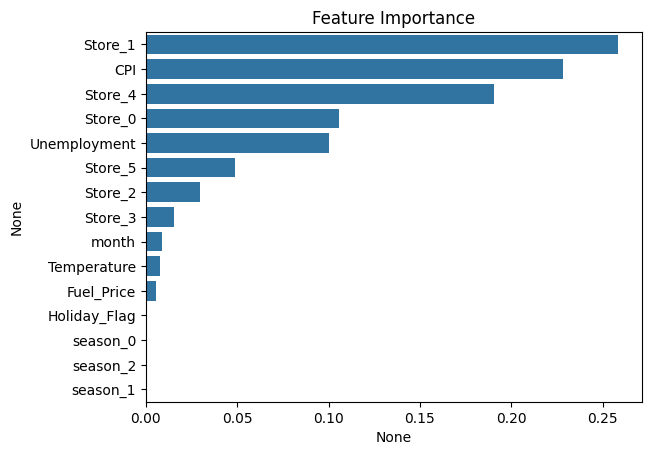

In [139]:
feature_imp=pd.Series(dec_tree.feature_importances_,index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp,y=feature_imp.index)
plt.title('Feature Importance')

### 5. Random Forest

In [140]:
# building the model
random_forest = RandomForestRegressor(n_jobs=-1)

# hyperparameter tunning
param_grid = {
    'max_depth': np.arange(2,15),
    'n_estimators': np.arange(25,101,25)
}
random_forest = finetune_and_evaluate(random_forest,param_grid)

Best Parameters: {'max_depth': 14, 'n_estimators': 100}
Best Score: 0.9471507575709988
Train accuracy 99.1
Test accuracy 94.89999999999999


### 6. XGBoost

In [141]:
xgb=XGBRegressor(n_jobs=-1)

param_grid={
    'max_depth': np.arange(2,10),
    'n_estimators':np.arange(20,201,20)
}

xgb=finetune_and_evaluate(xgb,param_grid)

Best Parameters: {'max_depth': 7, 'n_estimators': 80}
Best Score: 0.9622281007265194
Train accuracy 99.7
Test accuracy 96.7


In [142]:
with open('xgb.pkl','wb') as f:
    pickle.dump(xgb,f)